In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from dython.nominal import associations
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,\
                            f1_score, roc_auc_score,ConfusionMatrixDisplay
%matplotlib inline
%matplotlib notebook

def zscores(df):
    z_t = df.copy()
    col_zscore = "capital-gain" + "_zscore"
    z_t[col_zscore] = (z_t["capital-gain"] - z_t["capital-gain"].mean())/z_t["capital-gain"].std(ddof=0)
    z_t["outlier"] = (abs(z_t["capital-gain_zscore"])>2).astype(int)
    a = z_t[z_t["outlier"] == 1]["capital-gain"].sort_values()
    print(a)

In [4]:
def check_outlier(df):
    global z_t
    
    z_t = df.copy()
    print("\n ")
    print("########################### Additional Checking for Categrical Variables\n\n ")
    print(z_t[['education-num',"education"]].drop_duplicates().sort_values(by='education-num'))   
    workc_outl= z_t[z_t["workclass"] == "?"]
    
    print("\n\n######Records having '?'\n")
    print("{} records have '?' in workclass".format(len(workc_outl)))
    print("{} of them having '?' in occupation columns"
          .format(len(workc_outl[workc_outl["occupation"]=="?"])))
    print("{} of them have '>50K' in salary'"
         .format(len(workc_outl[workc_outl["salary"]==">50K"])))
    print("{} of them have values greater than 40 in hours-per-week"
         .format(len(workc_outl[workc_outl["hours-per-week"] >40])))
    a = workc_outl[workc_outl["hours-per-week"] >40]
    print("{} of people working longer than 40 hours have >50K in salary"
         .format(len(a[a["salary"]=='>50K'])))
    
        
    print("\n")
    print("###### The caplital-gain having 99999 \n")
    #haing 99999, 0
    print("{} of the record are 99999".format(len(z_t[z_t["capital-gain"] == 99999])))
    cap_0 = z_t[z_t["capital-gain"] == 0]
    l_cap_0 = len(cap_0)
    cap_0_p = len(cap_0)/len(z_t)*100
    print("{} of the record are 0; {} % of the records".format(l_cap_0, cap_0_p))

    t= z_t[z_t["capital-gain"] != 0]
    print("\n{} of the recordes are not 0".format(len(t)))
    print("The mean of the records excpet for 0 is {} ".format(t["capital-gain"].mean()))
    print("The median of the records excpet for 0 is {} ".format(t["capital-gain"].median()))

    a =  z_t[z_t["capital-gain"] != 99999]
    print("\nThe mean of the recordes excpet for 99999 is  {}".format(a["capital-gain"].mean()))
    print("\nThe median of the recordes excpet for 99999 is  {}".format(a["capital-gain"].median()))

    t_1 = t[t["capital-gain"] != 99999]
    print("{} of the records are excpet for 0 and 99999 ".format(len(t_1)))
    print("The mean of the records except for 0 and 99999 is {}".format(t_1["capital-gain"].mean()))
    print("The median of the records excpet for 0 and 99999 is {}".format(t_1["capital-gain"].median()))
    
    print("Outliers decide by Z-Scores : 91% 0 ")
    zscores(df)
    
    print("Outliers decide by Z-Scores : Except for 0 ")
    n_zero = z_t[z_t["capital-gain"] !=0]
    zscores(df)

In [5]:
def corr_v(df, c_list,asso):    
    print("\n\n######################      Association between Variavles     ######################\n\n")
    t = df[c_list].copy()
    fig, ax = plt.subplots(figsize = (10, 10))
    print("################ {}".format(asso))
    if asso == "theil" :
        theil = associations(t, nom_nom_assoc = asso, ax = ax, cmap = "Blues")
    elif asso == "correlation_ratio":
        corr_r = associations(t, nom_num_assoc =asso , ax = ax, cmap = "Blues")
    else:   
        pearson = associations(t, num_num_assoc =asso , ax = ax, cmap = "Blues")

In [6]:
def explore_df(df, sep =1):
    global cat_list
    cat_list = ["workclass", "marital-status", "occupation",
                "relationship", "race", "sex","native-country", "salary"]
    global conti_list
    conti_list = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
    
    global l_df
    l_df = df.shape[0]
    
    print("##################################### Exploring {} ####################################".format(df.names))
    print("\n[Shape of {}]\n".format(df.names))
    print(df.shape)
    
    print("\n[Head of {}]".format(df.names))
    display(df.head(3))

    drop_col = "fnlwgt"
    if sep == 1:    
        print("\n######  rename columns ")
        df.rename(columns={0:"age", 1:"workclass", 2:"fnlwgt", 3:"education", 4:"education-num", 
                       5:"marital-status", 6:"occupation", 7:"relationship", 8:"race", 9:"sex", 
                       10:"capital-gain", 11:"capital-loss", 12:"hours-per-week", 
                       13:"native-country", 14:"salary"}, inplace=True)    
        print("\n######  drop {} \n".format(drop_col))
        df.drop(["fnlwgt"], axis=1, inplace=True)
        print("\n[Head : after renaming columns]")
        display(df.head(3))
        
    print("\n[columns of {}]\n".format(df.names))
    display(pd.Series(df.columns))
    
    print("\n[information of {}]\n".format(df.names))
    display(pd.DataFrame(df.info()))
    
    print("\n[Descriptive Statistics of {}]".format(df.names))
    display(pd.DataFrame(df.describe()))  
    
    print("\n[Recheck null values]\n")
    print("The toal of null values are ", sum(df.isnull().sum()))
    
    if sep == 1: 
        check_outlier(df)
    
        df.drop(["education"], axis =1, inplace=True)
        print("\n\n###### drop education \n\n")
    
        t_list= conti_list.copy()
        t_list.append("salary")
        corr_v(df, cat_list,'theil')
        corr_v(df, t_list,'correlation_ratio')        

In [7]:
def explore_cat(df, col, sep):
    vc = df[col].value_counts()
    l_vc = len(vc)
    a = pd.DataFrame(vc)
    a["percent"] = round(a[col].apply(lambda x : x/l_df*100),1)    
    
    print("\n[Values in {} column]\n".format(col))
    print(a)
    
    if sep == 1:
        if l_vc < 16 :
            fig,ax = plt.subplots(nrows=1, ncols= 2, figsize =(10,4))
            vc.plot.bar(ax=ax[0])
            sns.countplot(ax=ax[1], x=col, data=df, hue="salary", palette="rainbow", order=vc.index)
    
        else :
            fig, ax = plt.subplots(nrows=2, ncols= 1, figsize =(11,10))
            vc.plot.bar(ax=ax[0])
            sns.countplot(ax=ax[1], x=col, data=df, hue="salary", palette="rainbow", order=vc.index)
    
        plt.suptitle("----------------- {} ----------------- ".format(col))
        plt.xticks(rotation="vertical")
        plt.subplots_adjust(hspace = 0.9, wspace = 0.4, bottom=0.5)
        plt.show();
    else:
        nc = df[col].isna().sum()
        print("\nNull values(converted ? to None) in {} is {}\n".format(col, nc))        

In [1]:
def details_cat(df):
    print("\n###########People workclass is 'Self-emp-inc'" )
    print(df[df["workclass"] == "Self-emp-inc"].groupby("salary")["workclass"].agg('count'))
    
    n_m_low = round(len(df[df["marital-status"] == "Never-married"])/ len(df)*100,2)
    d_low = round(len(df[df["marital-status"] == "Divorced"])/ len(df)*100,2)
    print("\n{}% of Never married people and {} of Divorced people blonged to the low income group".format(n_m_low, d_low))
    
    a= df[df["marital-status"] == "Never-married"]
    print("\n{} People are Never married".format(len(a)))
    g_a=a.groupby("salary")["marital-status"].agg('count')
    p_low = g_a[0]/len(a)*100
    print("{} percent fo Never married peope are inlow income level".format(p_low))
    
    a= df[df["marital-status"] == "Divorced"]
    print("\n{} People are divorced".format(len(a)))
    g_a=a.groupby("salary")["marital-status"].agg('count')
    p_low = g_a[0]/len(a)*100
    print("{} percent of divorced peope are inlow income level".format(p_low))
    
    print("\n Salary Group of occupation")   
    l_occu = len(df)
    print(df.groupby(["occupation","salary"])["salary"].count())
    
    print("\n Salary Group of occupation")  
    l_occu = len(df)
    print(df.groupby(["relationship","salary"])["salary"].count())
    
    print("\n Salary Group of relationship")  
    l_occu = len(df)
    print(df.groupby(["relationship","salary"])["salary"].count())

In [9]:
def result_explore_cat(df):
    
    print("\n############################ Exploring Categorical Variables #########################")
    for col in cat_list:
        explore_cat(df, col, 1)
    details_cat(df)    

In [10]:
def manip_cat_v(df, col_list):
    print("###################### Manipulating Categorical Variables ####################")
    print("------------- Convert '?' to 'None' ---------------")
    for col in col_list: 
        print("\n[ {} __after converting '?' to None]".format(col))
        chk_spec = df[col] == "?"
        df.loc[chk_spec, col] = None
        explore_cat(df, col,2)
    return df

In [11]:
def explore_conti(df, col):
    print("\n-------------------------- {} -----------------------".format(col))
    print("min : ", df[col].min(), ", max : ",df[col].max())    
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize= (10,5))
    sns.boxplot(x= df[col], ax=ax[0])
    sns.histplot(x= df[col],ax=ax[1])
    ax2 = ax[1].twinx()
    sns.kdeplot(x= df[col], hue=df["salary"],  ax=ax2)
    fig.suptitle("--------------------------    {}    --------------------------".format(col))
    plt.subplots_adjust(hspace = 0.4, wspace = 0.2, bottom=0.3)
    plt.show();

In [12]:
def result_explore_conti(df):
    
    print("########################## Exploring Continous Variables #########################")
        
    for col in conti_list:
        explore_conti(df, col)

In [13]:
def manip_con_v(df, col_list):
    print("############################### Manipulating Continuous Variables #############################")
    print("\n------------- Convert 99999 to np.nan ---------------")
    t = df.copy()
    
    # dataset for KNN Imputation
    for col in col_list:         
        chk_spec = t[col] == 99999
        t.loc[chk_spec, col] = np.nan
        print("\n[ {} __after converting 99999 to np.nan]".format(col))
        explore_conti(t, col)
       
    return t

## [KNN imputation] </br>Encoding Categorical data using LabelEncoder </br> KNN Imputation

In [14]:
def encode_cat(df_t, c_list):
    df = df_t.copy()
    global dic_labels
    dic_labels ={}
    le = LabelEncoder()
    
    for s in c_list:
        dic_labels[s] = {}
        df[s] = le.fit_transform(df[s])      
        dic_label = dict(zip(le.classes_, le.transform(le.classes_)))
        dic_labels[s] = dic_label
    return df, dic_labels

In [15]:
def labels_to_df(dic):
    print('\n##################################### Labels for encoding ##################################\n')
    for i in dic.keys():        
        df_name = i        
        df_name = pd.DataFrame.from_dict([dic[i]])        
        df_name.rename(index={0:i}, inplace=True)        
        if df_name.shape[1] >21:
            display(df_name.iloc[:,:15])
            display(df_name.iloc[:,15:31])
            display(df_name.iloc[:,31:])
        else: 
            display(df_name)
        print("\n") 

In [16]:
def conv_na(df, c_list):
    print('\n-------------------- convert None to np.nan before KNN inputation --------------------\n\n')
    for s in c_list:
        df.loc[df[s]==None, s] = np.nan
    return df

In [17]:
def K_imputer(df, k=3):
    imputer = KNNImputer(n_neighbors=k)
    imputed_df= pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
    imputed_df.names = "After KNN Imputation"
    return imputed_df

In [18]:
def KNN_imp(df, c_list): 
    imp_t, dic_labels = encode_cat(df, c_list)
    imp_t.names = "After Lable-Encoding Categ-Variables"
    
    print("##################################### After Label_Encoding ################################ ")
    display(imp_t)
    labels_to_df(dic_labels)
    
    con_nan = conv_na(imp_t, c_list)
    imputed_df = K_imputer(con_nan, k =29)
    
    explore_df(imputed_df, 2)
    return imputed_df

## MODELING 

In [19]:
def s_dataset(df, y_col, c_list, dum):
    print('\n\n##################### DataFrame : {}  #####################'.format(df.names))
    scaler = MinMaxScaler(feature_range=(0,1))
    
    t = df.copy()
    X = t.drop([y_col], axis=1)
    X_d = pd.get_dummies(data = X, columns = c_list[:-1], drop_first=True)
    
    y = df[y_col]
    y = pd.get_dummies(data = y, drop_first=True)

    if dum == 0:
        print("---------------------------- Dummy Encoding (X) ---------------------")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        n_scaler = MinMaxScaler().fit(X_train)
        X_train = n_scaler.transform(X_train)
        X_test = n_scaler.transform(X_test)
        
    else:
        print("---------------------------- Dummy Encoding (O) ---------------------")
        X_train, X_test, y_train, y_test = train_test_split(X_d, y, test_size=0.2, random_state=0)
        n_scaler = MinMaxScaler().fit(X_train)
        X_train = n_scaler.transform(X_train)
        X_test = n_scaler.transform(X_test)
    
    print("\n\n-------------------------------  X -------------------------------")
    display(X.head(3))
    
    print("\n\n-------------------------------  y  -------------------------------")
    display(y.head(3))
    
    print(' Split Datasets : X_train{}, X_test{}, y_train{}, y_test{}'.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))
    return X_train, X_test, y_train, y_test

In [20]:
def evaluating_models(X_tr, X_te, y_te, r_pre, model, average):
    
    aver = average
    confusion = confusion_matrix(y_te, r_pre)
    accuracy = accuracy_score(y_te, r_pre)
    precison = precision_score(y_te, r_pre, average=aver)
    recall = recall_score(y_te, r_pre, average=aver)
    f1 = f1_score(y_te, r_pre, average=aver)
    std_score = model.score(X_te, y_te)
    

    print("confusion : \n", confusion)
    print("accuracy : ",accuracy)
    print("precison : ", precison)
    print("recall : ", recall)
    print("f1 :", f1)
    print("Std_score : ", std_score)
    
    cm = confusion_matrix(y_te, r_pre, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()

In [21]:
def ex_knn(X_train, X_test, y_train, y_test):

    
    knn = KNeighborsClassifier()
    
    n_nei = list(range(1,30,2))
    weight = ["uniform", "distance"]
    algo = ["auto","ball_tree","kd_tree","brute"]
    parameters = {"n_neighbors" :n_nei, "metric":["euclidean"], "weights":weight,"algorithm":algo}
    
    grid_knn = GridSearchCV(knn, param_grid =parameters, cv=5, refit = True)
    grid_knn.fit(X_train, y_train)
    
    scores = pd.DataFrame(grid_knn.cv_results_)
    best_p = grid_knn.best_params_
    best_s = grid_knn.best_score_
    
    return scores, best_p, best_s 

In [22]:
def ex_knn_final(X_train, X_test, y_train, y_test, param):
    
    knn = KNeighborsClassifier(algorithm= param['algorithm'], metric= param['metric'],n_neighbors= param['n_neighbors'], weights= param['weights'])
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)       
    
    return knn, pred 

In [23]:
def best_param(best_p_0, best_s_0,best_p_1, best_s_1):
    if best_s_0 > best_s_1:
        best_param = best_p_0
        flag = 0
    else:
        best_param = best_p_1
        flag = 1
    
    print("\n\nBest parameters :", best_param, "\n\n")
    
    return best_param, flag        

In [24]:
def feature_importance(X_train, X_test, y_train, y_test,df):
    
    fea_names = df.columns[:-1] 
    df_std_score = pd.DataFrame()
    t = pd.DataFrame(X_test)
    t.rename(columns={0:'age', 1: 'workclass', 2:'education-num', 3:'marital-status', 4: 'occupation', 
                          5:'relationship', 6:'race', 7:'sex', 8:'capital-gain', 9:'capital-loss',
                          10:'hours-per-week', 11:'native-country'}, inplace=True)
    print("\n\nOriginal X_test")
    display(t)
    
    for c in fea_names:
        t.copy()

        print("\n######################   Feature Test : {}   ############################".format(c))
        #print("X_text Before permutation")
        #display(t)
        
        print("\n----------------------  Before permutation : \n", t[c])
        permuted_X_v = np.random.permutation(t[c])
        print("\n----------------------   After permutation : \n", permuted_X_v)
        t[c] = permuted_X_v
        
        #print("\n----------------------  X_test After permuation : ")
        #display(t)
       

        std_score = knn.score(t,y_test)
        print("\naccuracy_score : {} ".format(std_score))
        df_std_score[c] = [std_score]
    print("\n\n######################################### Score Table #########################################\n")
    display(df_std_score)

In [25]:
def basic_knn(df, y_col, c_list):
    
    t = df.copy()
    X = t.drop([y_col], axis=1)    
    y = df[y_col]
    y = pd.get_dummies(data = y, drop_first=True)  
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)  
    
    return knn, pred, X_train, X_test, y_train, y_test 

##################################### Exploring Original Dataset ####################################

[Shape of Original Dataset]

(48842, 15)

[Head of Original Dataset]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K



######  rename columns 

######  drop fnlwgt 


[Head : after renaming columns]


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K



[columns of Original Dataset]



0                age
1          workclass
2          education
3      education-num
4     marital-status
5         occupation
6       relationship
7               race
8                sex
9       capital-gain
10      capital-loss
11    hours-per-week
12    native-country
13            salary
dtype: object


[information of Original Dataset]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   education       48842 non-null  object
 3   education-num   48842 non-null  int64 
 4   marital-status  48842 non-null  object
 5   occupation      48842 non-null  object
 6   relationship    48842 non-null  object
 7   race            48842 non-null  object
 8   sex             48842 non-null  object
 9   capital-gain    48842 non-null  int64 
 10  capital-loss    48842 non-null  int64 
 11  hours-per-week  48842 non-null  int64 
 12  native-country  48842 non-null  object
 13  salary          48842 non-null  object
dtypes: int64(5), object(9)
memory usage: 5.2+ MB


""



[Descriptive Statistics of Original Dataset]


,age,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,10.078089,1079.067626,87.502314,40.422382
std,13.710510,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000



[Recheck null values]

The toal of null values are  0

 
########################### Additional Checking for Categrical Variables

 
     education-num     education
224              1     Preschool
160              2       1st-4th
56               3       5th-6th
15               4       7th-8th
6                5           9th
77               6          10th
3                7          11th
415              8          12th
2                9       HS-grad
10              10  Some-college
14              11     Assoc-voc
13              12    Assoc-acdm
0               13     Bachelors
5               14       Masters
52              15   Prof-school
20              16     Doctorate


######Records having '?'

2799 records have '?' in workclass
2799 of them having '?' in occupation columns
265 of them have '>50K' in salary'
327 of them have values greater than 40 in hours-per-week
70 of people working longer than 40 hours have >50K in salary


###### The caplital-gain having 99999 


<IPython.core.display.Javascript object>


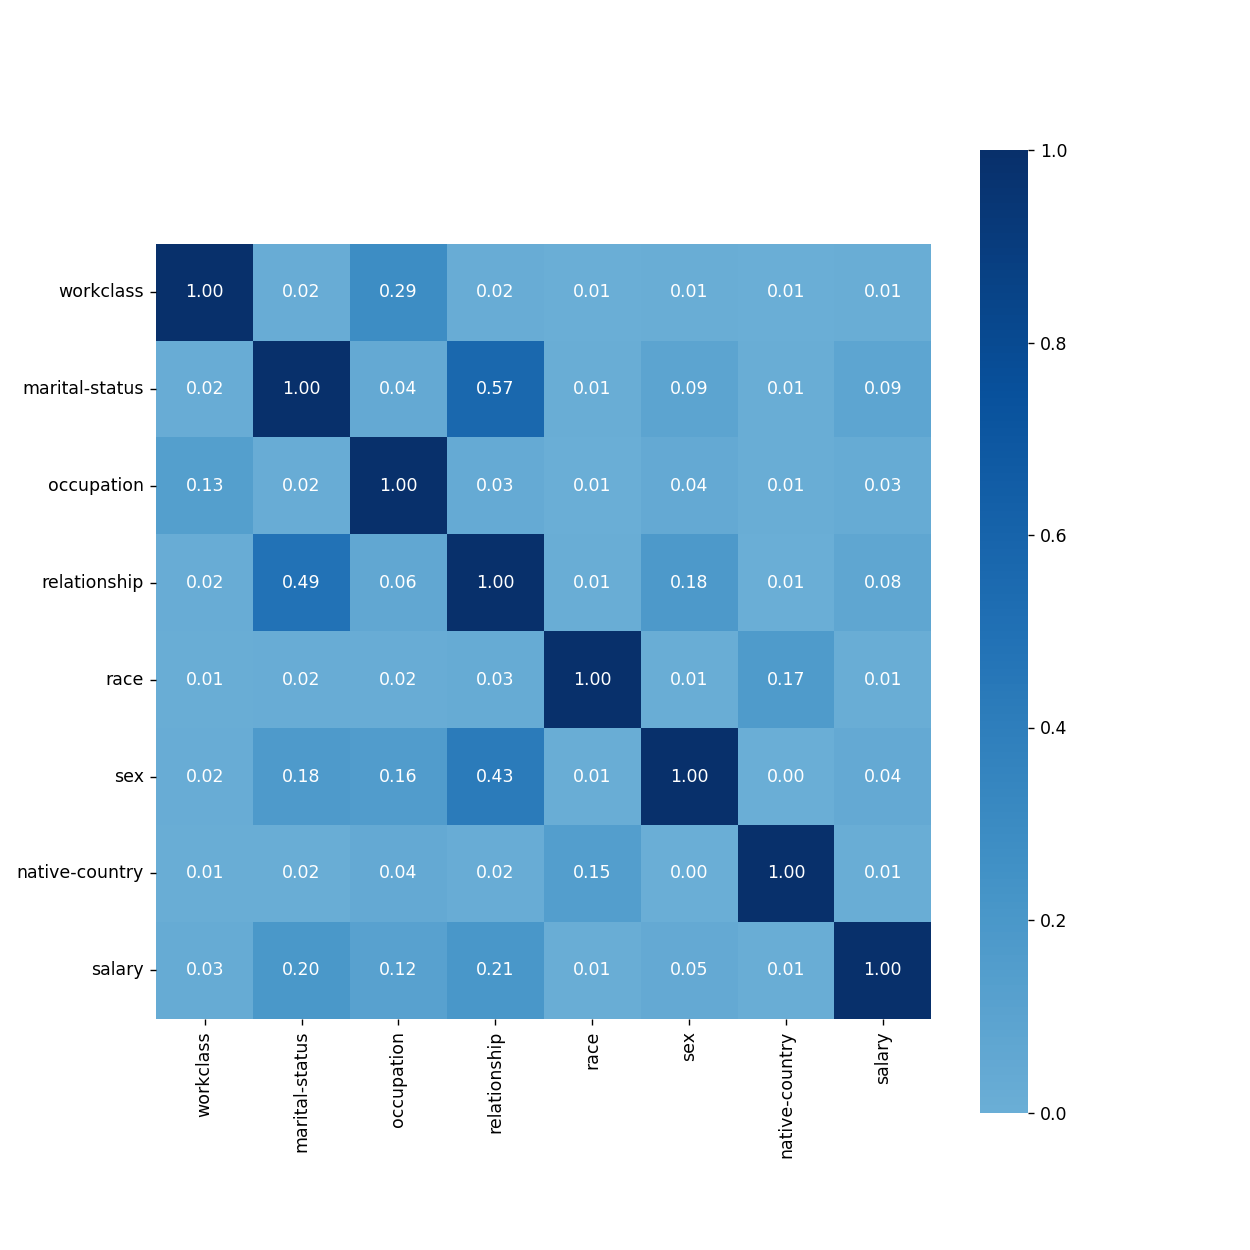

################ theil


######################      Association between Variavles     ######################




<IPython.core.display.Javascript object>


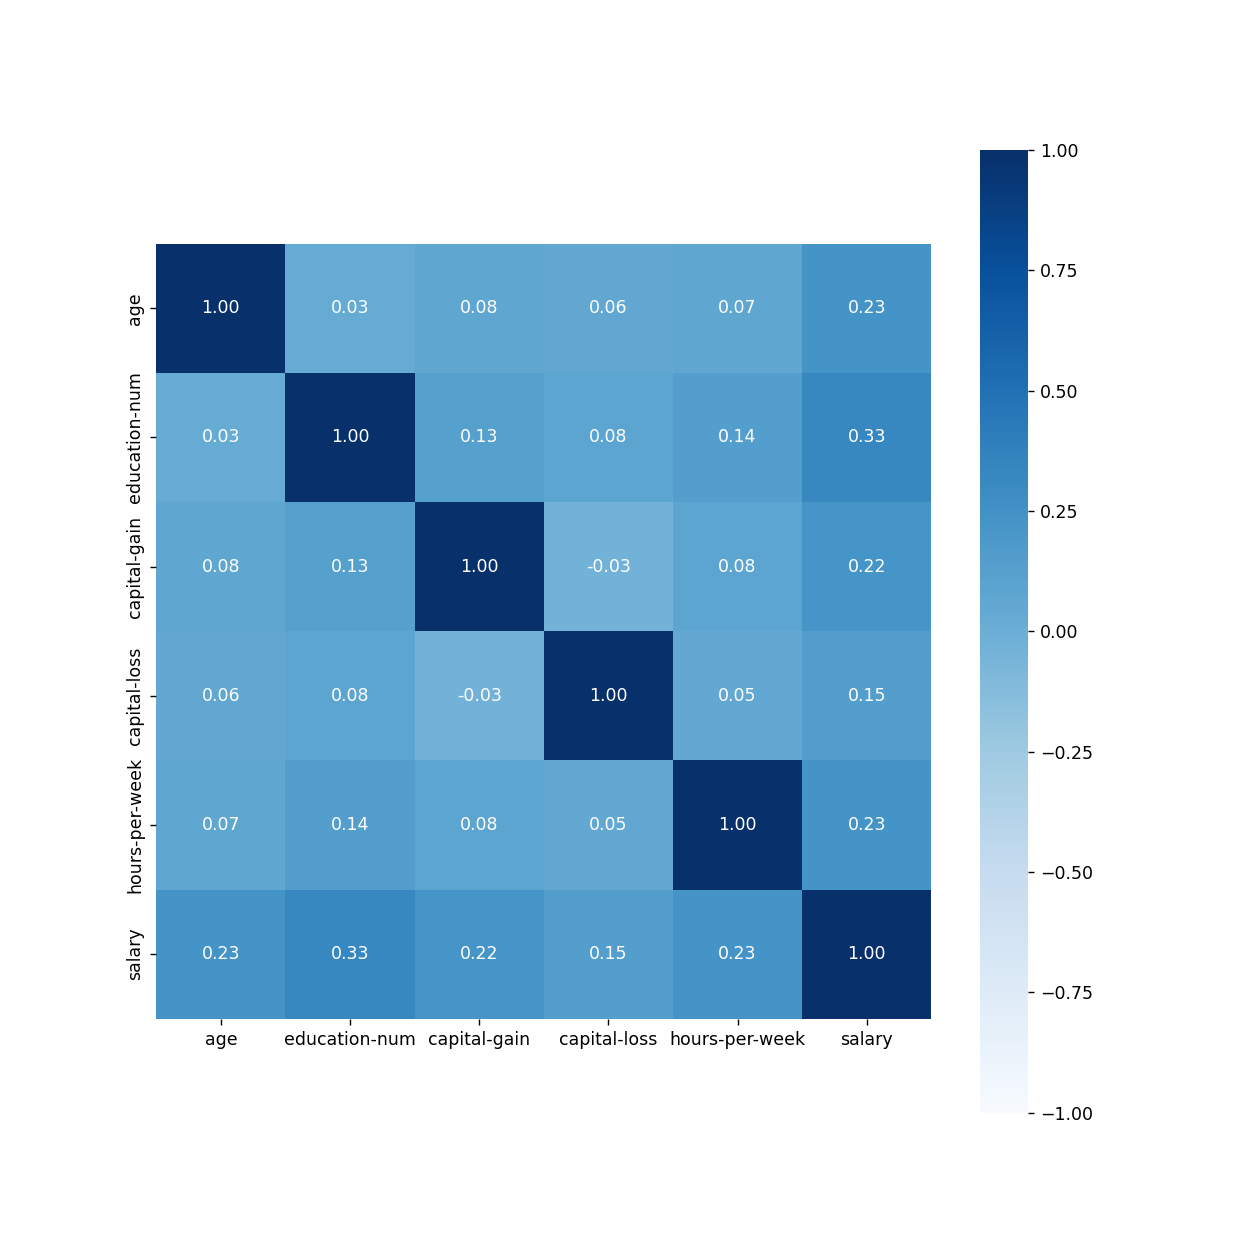

################ correlation_ratio

############################ Exploring Categorical Variables #########################

[Values in workclass column]

                  workclass  percent
Private               33906     69.4
Self-emp-not-inc       3862      7.9
Local-gov              3136      6.4
?                      2799      5.7
State-gov              1981      4.1
Self-emp-inc           1695      3.5
Federal-gov            1432      2.9
Without-pay              21      0.0
Never-worked             10      0.0


<IPython.core.display.Javascript object>


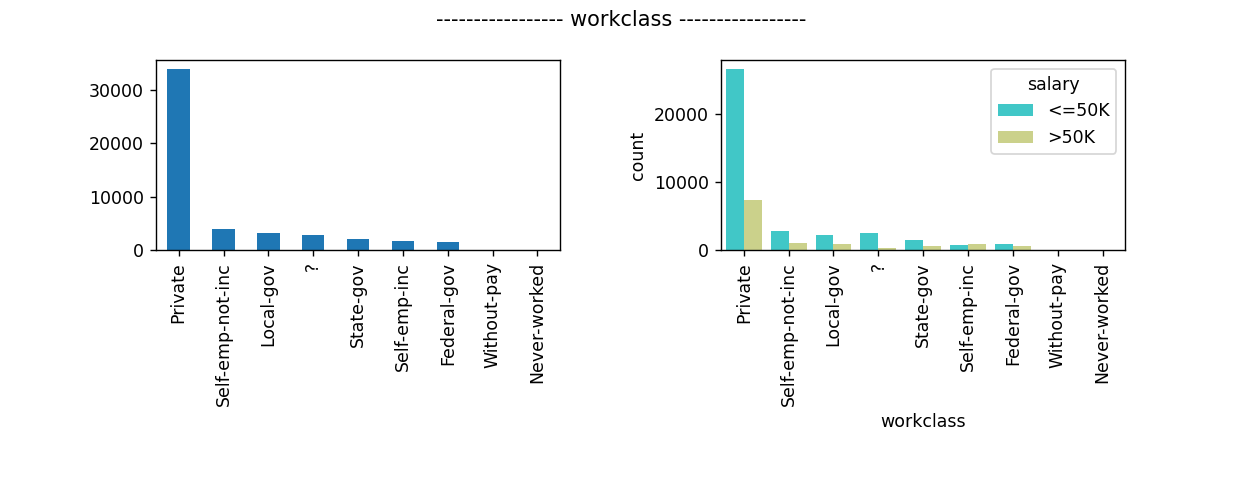


[Values in marital-status column]

                       marital-status  percent
Married-civ-spouse              22379     45.8
Never-married                   16117     33.0
Divorced                         6633     13.6
Separated                        1530      3.1
Widowed                          1518      3.1
Married-spouse-absent             628      1.3
Married-AF-spouse                  37      0.1


<IPython.core.display.Javascript object>


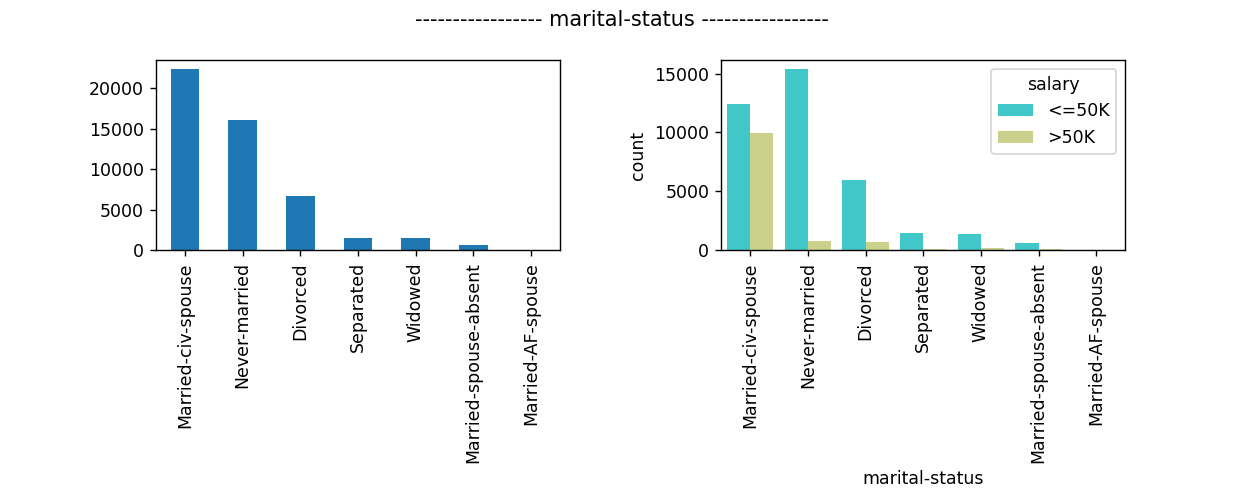


[Values in occupation column]

                   occupation  percent
Prof-specialty           6172     12.6
Craft-repair             6112     12.5
Exec-managerial          6086     12.5
Adm-clerical             5611     11.5
Sales                    5504     11.3
Other-service            4923     10.1
Machine-op-inspct        3022      6.2
?                        2809      5.8
Transport-moving         2355      4.8
Handlers-cleaners        2072      4.2
Farming-fishing          1490      3.1
Tech-support             1446      3.0
Protective-serv           983      2.0
Priv-house-serv           242      0.5
Armed-Forces               15      0.0


<IPython.core.display.Javascript object>


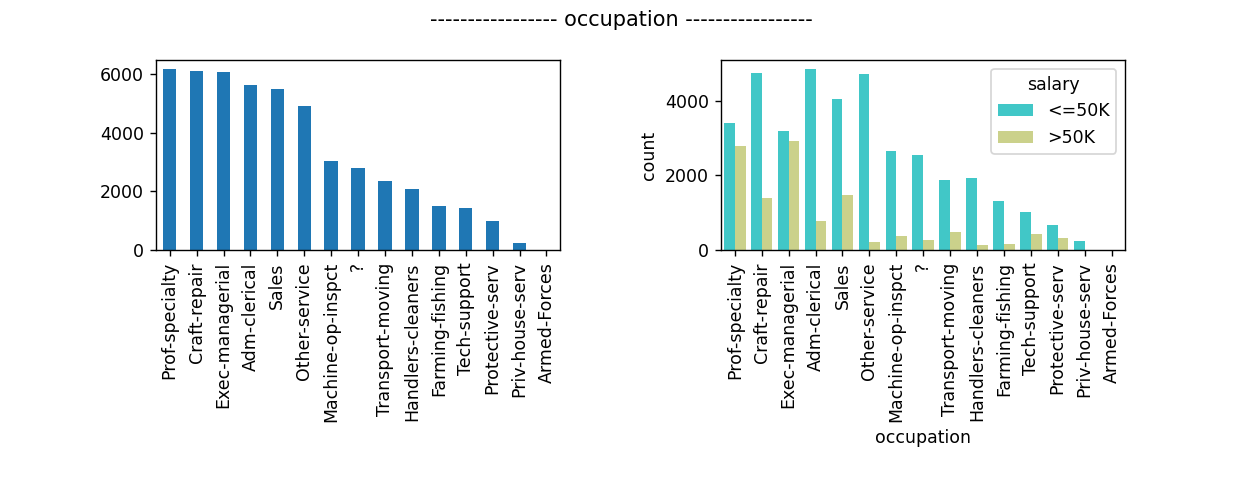


[Values in relationship column]

                relationship  percent
Husband                19716     40.4
Not-in-family          12583     25.8
Own-child               7581     15.5
Unmarried               5125     10.5
Wife                    2331      4.8
Other-relative          1506      3.1


<IPython.core.display.Javascript object>


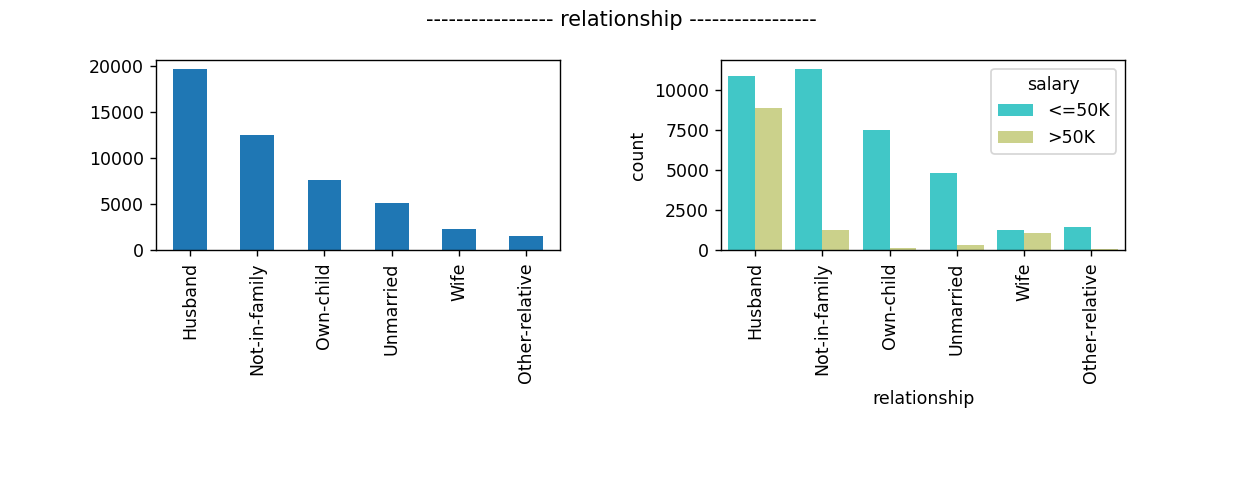


[Values in race column]

                     race  percent
White               41762     85.5
Black                4685      9.6
Asian-Pac-Islander   1519      3.1
Amer-Indian-Eskimo    470      1.0
Other                 406      0.8


<IPython.core.display.Javascript object>


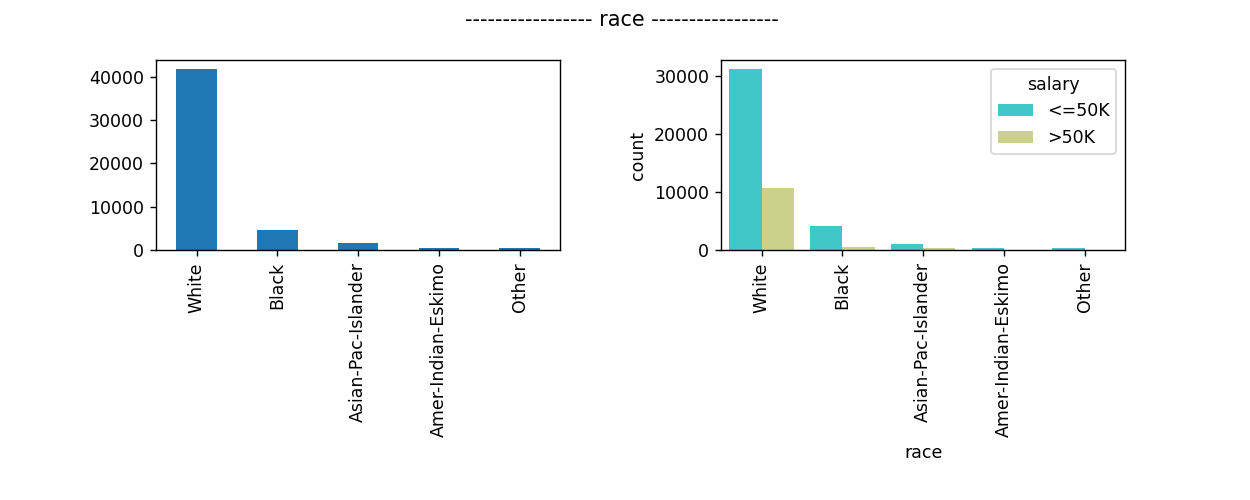


[Values in sex column]

          sex  percent
Male    32650     66.8
Female  16192     33.2


<IPython.core.display.Javascript object>


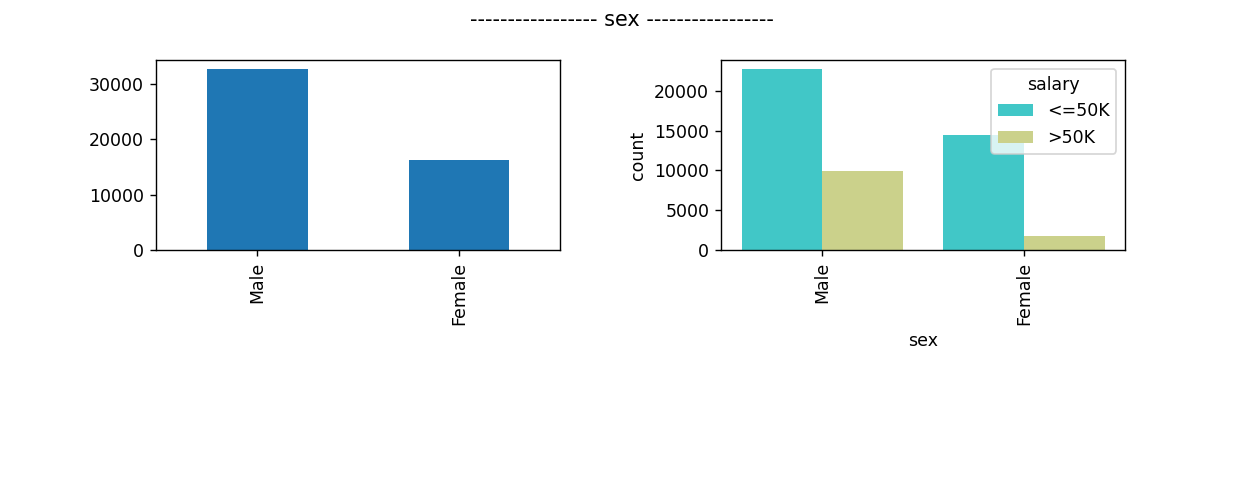


[Values in native-country column]

                            native-country  percent
United-States                        43832     89.7
Mexico                                 951      1.9
?                                      857      1.8
Philippines                            295      0.6
Germany                                206      0.4
Puerto-Rico                            184      0.4
Canada                                 182      0.4
El-Salvador                            155      0.3
India                                  151      0.3
Cuba                                   138      0.3
England                                127      0.3
China                                  122      0.2
South                                  115      0.2
Jamaica                                106      0.2
Italy                                  105      0.2
Dominican-Republic                     103      0.2
Japan                                   92      0.2
Guatemala                   

<IPython.core.display.Javascript object>


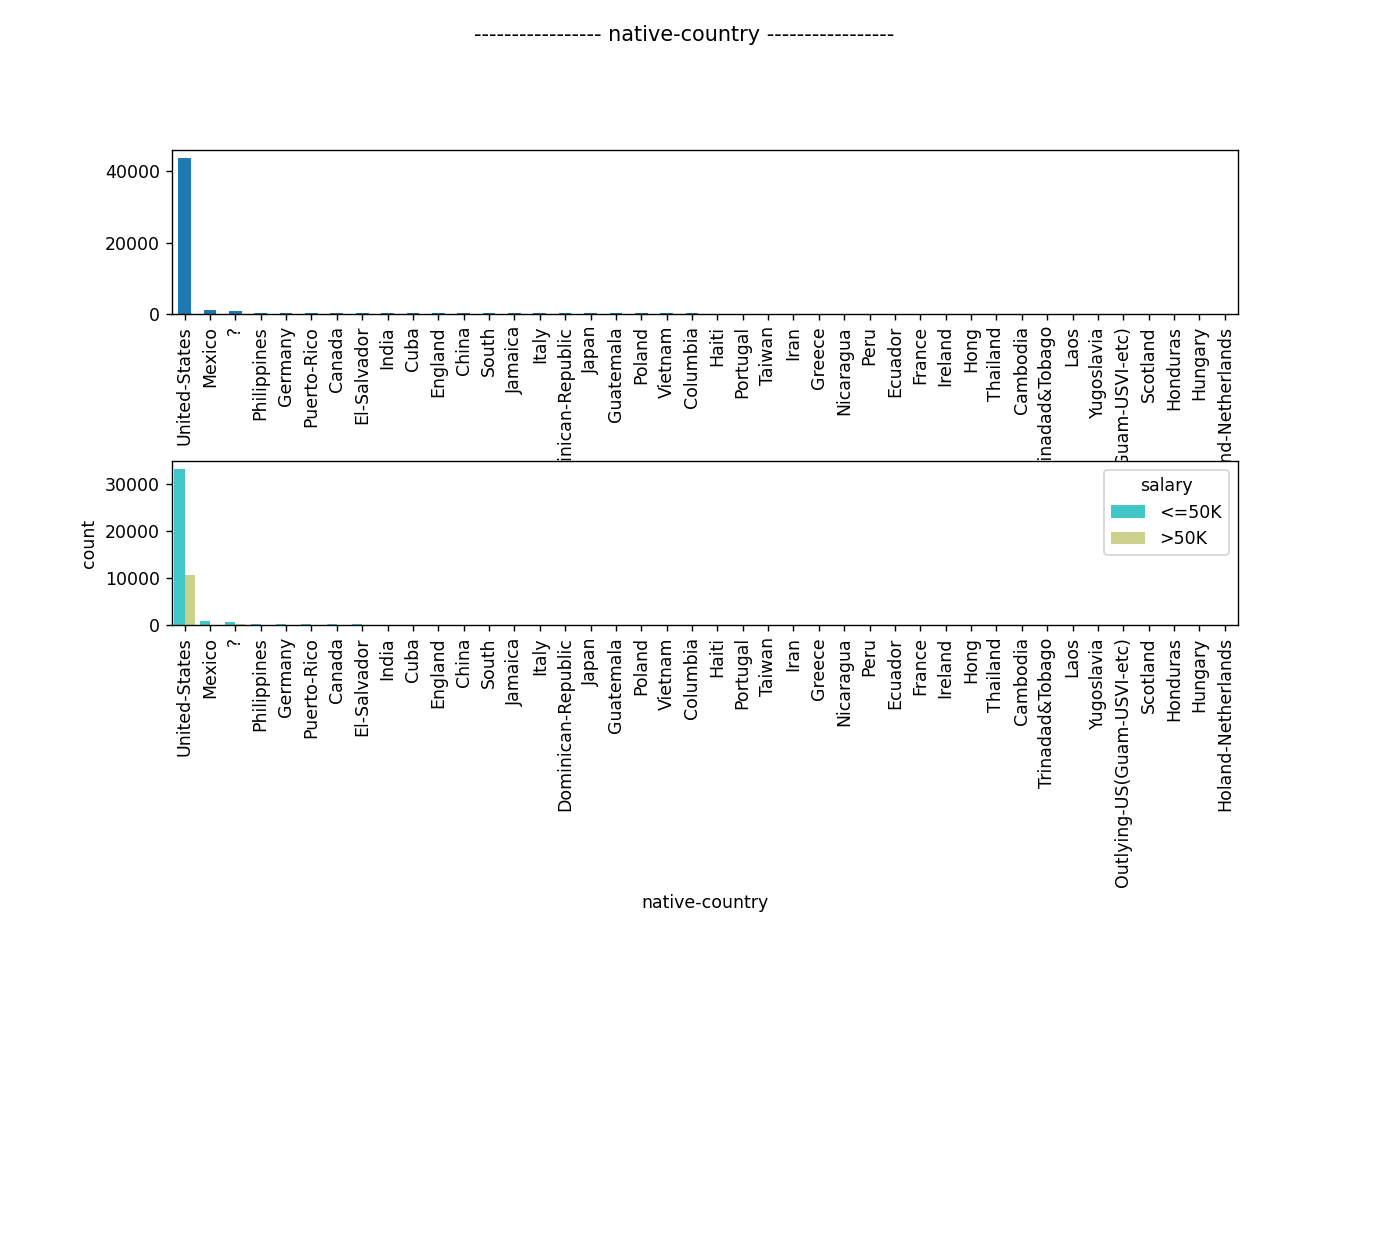


[Values in salary column]

       salary  percent
<=50K   37155     76.1
>50K    11687     23.9


<IPython.core.display.Javascript object>


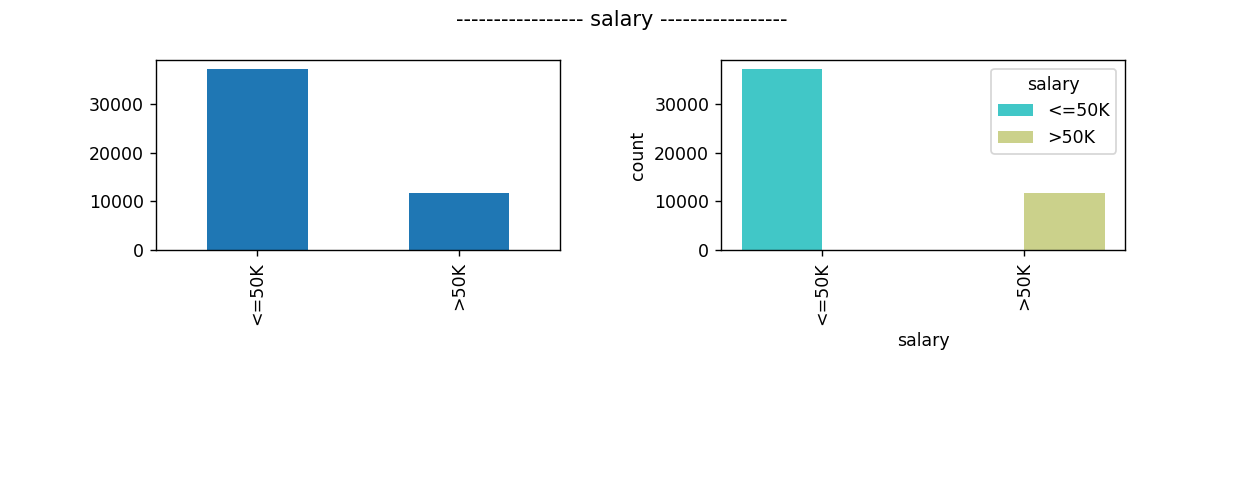


###########People workclass is 'Self-emp-inc'
salary
<=50K    757
>50K     938
Name: workclass, dtype: int64

33.0% of Never married people and 13.58 of Divorced people blonged to the low income group

16117 People are Never married
95.45200719736924 percent fo Never married peope are inlow income level

6633 People are divorced
89.88391376451078 percent of divorced peope are inlow income level

 Salary Group of occupation
occupation         salary
?                  <=50K     2544
                   >50K       265
Adm-clerical       <=50K     4843
                   >50K       768
Armed-Forces       <=50K       10
                   >50K         5
Craft-repair       <=50K     4729
                   >50K      1383
Exec-managerial    <=50K     3178
                   >50K      2908
Farming-fishing    <=50K     1317
                   >50K       173
Handlers-cleaners  <=50K     1934
                   >50K       138
Machine-op-inspct  <=50K     2650
                   >50K       372
Ot

<IPython.core.display.Javascript object>


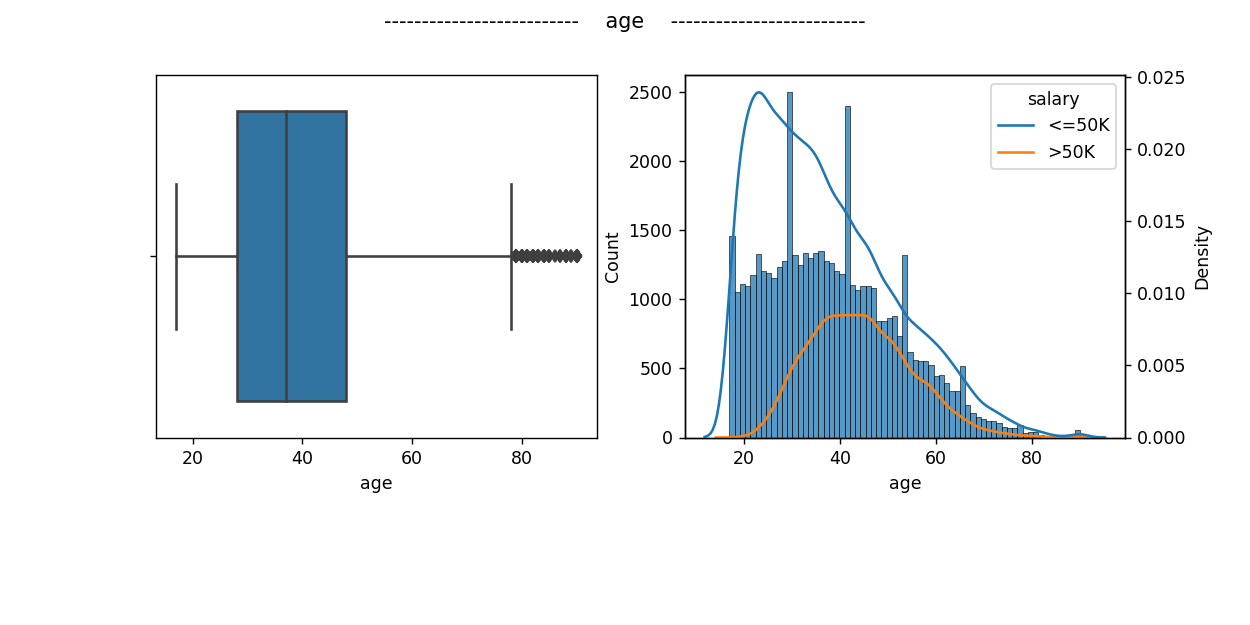


-------------------------- education-num -----------------------
min :  1 , max :  16


<IPython.core.display.Javascript object>


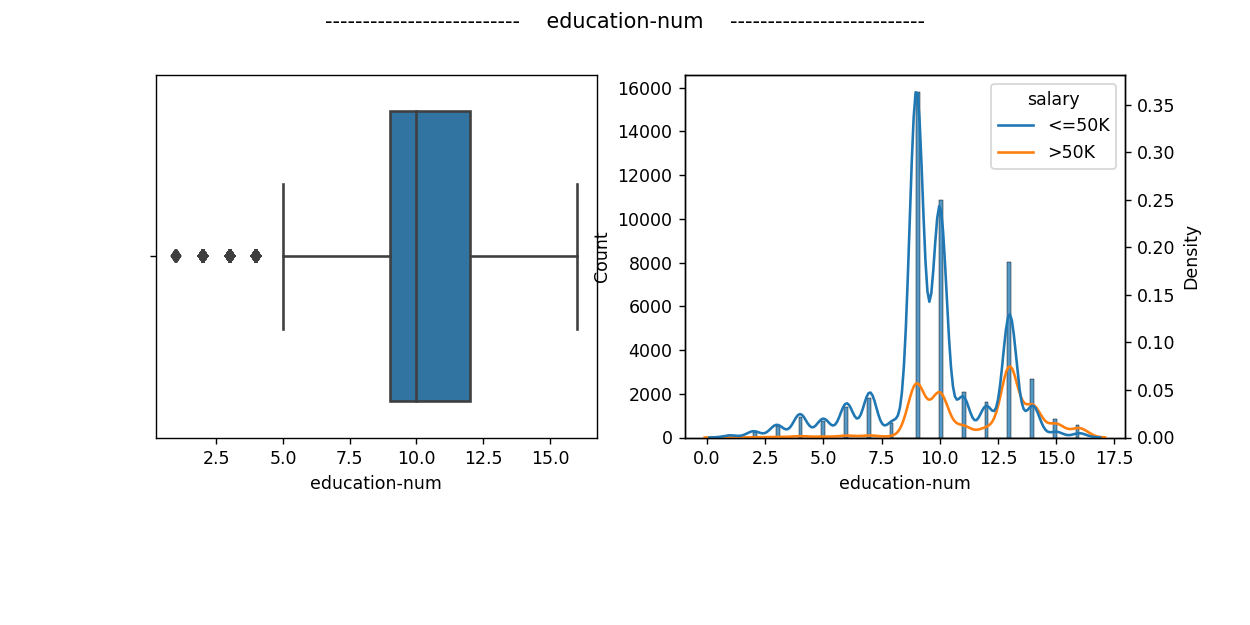


-------------------------- capital-gain -----------------------
min :  0 , max :  99999


<IPython.core.display.Javascript object>


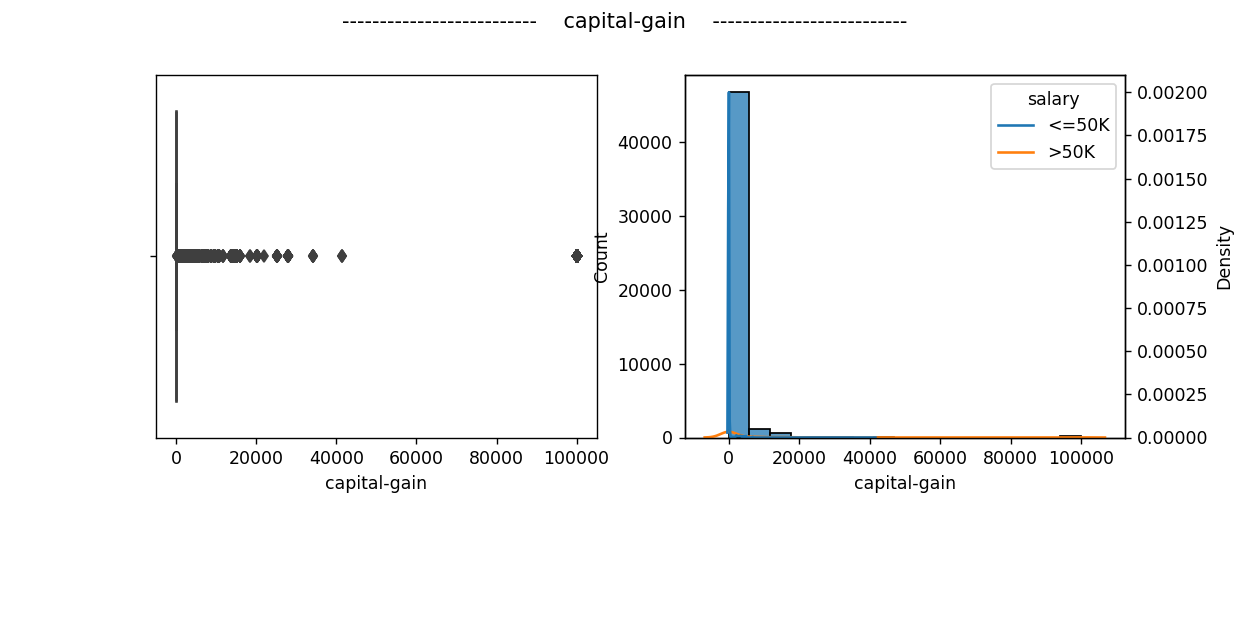


-------------------------- capital-loss -----------------------
min :  0 , max :  4356


<IPython.core.display.Javascript object>


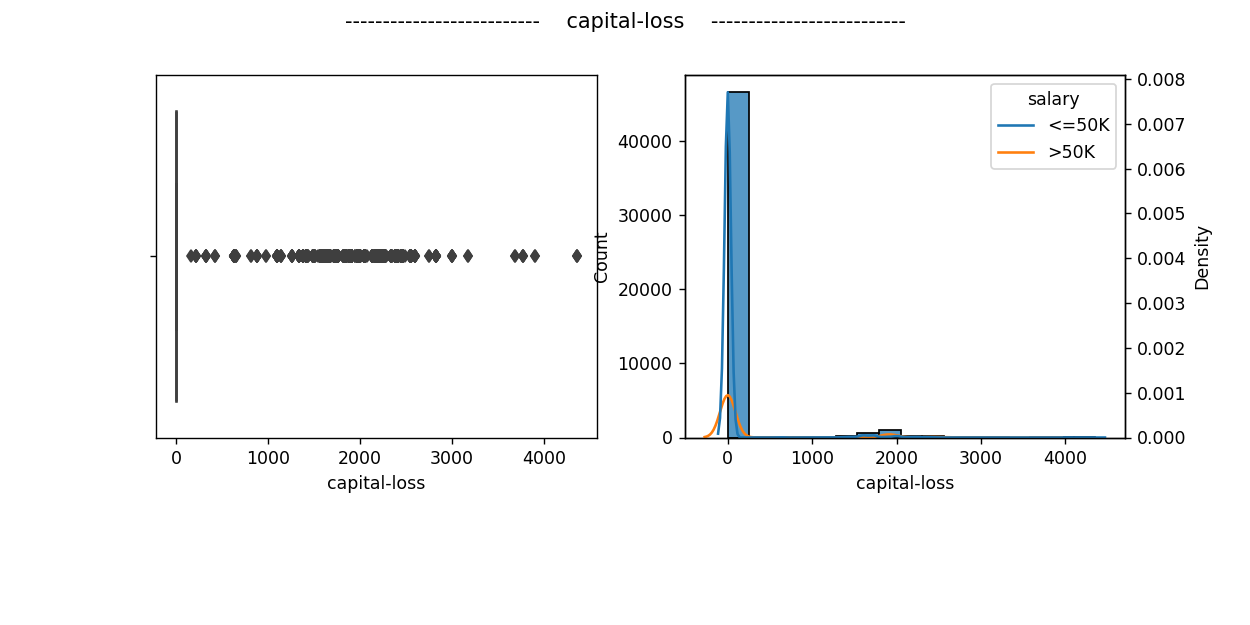


-------------------------- hours-per-week -----------------------
min :  1 , max :  99


<IPython.core.display.Javascript object>


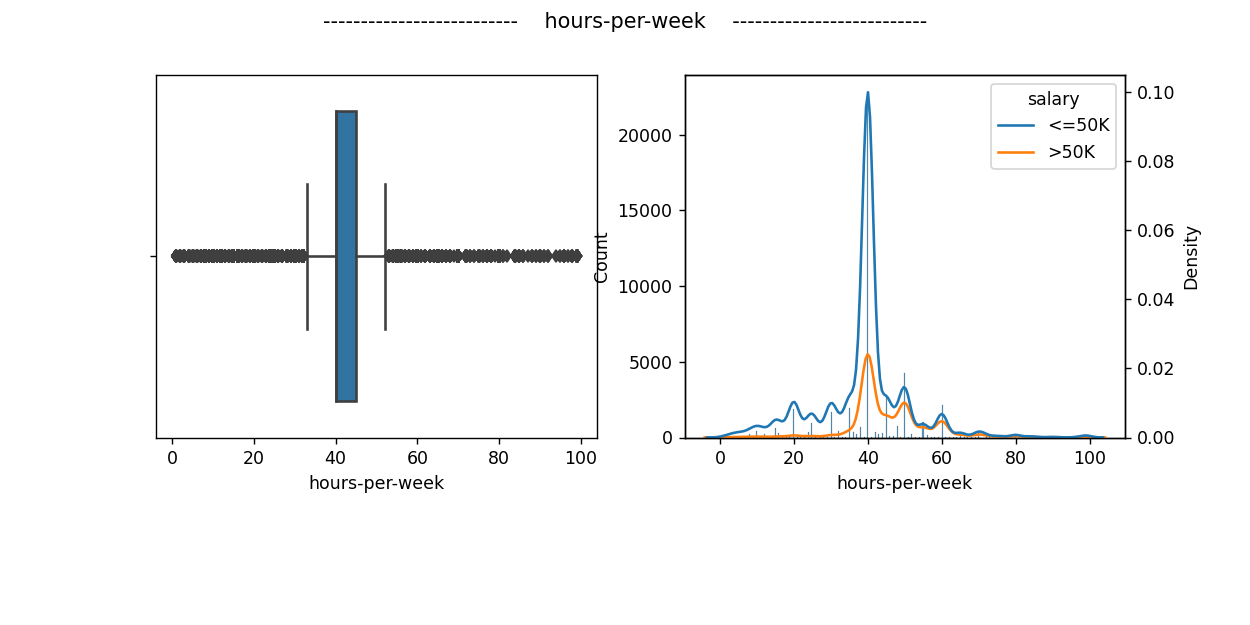

############################### Manipulating Continuous Variables #############################

------------- Convert 99999 to np.nan ---------------

[ capital-gain __after converting 99999 to np.nan]

-------------------------- capital-gain -----------------------
min :  0.0 , max :  41310.0


<IPython.core.display.Javascript object>


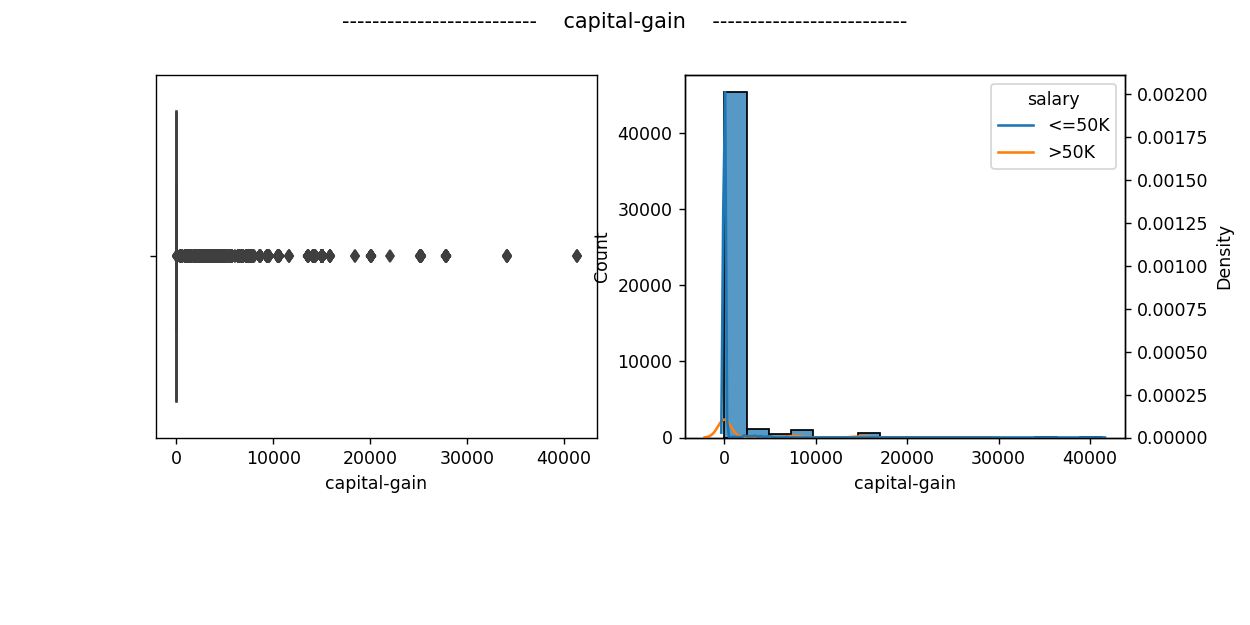

##################################### Exploring before KNN imputation(+nan/None) ####################################

[Shape of before KNN imputation(+nan/None)]

(48842, 13)

[Head of before KNN imputation(+nan/None)]


,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0,40,United-States,<=50K
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0,13,United-States,<=50K
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0,40,United-States,<=50K



[columns of before KNN imputation(+nan/None)]



0                age
1          workclass
2      education-num
3     marital-status
4         occupation
5       relationship
6               race
7                sex
8       capital-gain
9       capital-loss
10    hours-per-week
11    native-country
12            salary
dtype: object


[information of before KNN imputation(+nan/None)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             48842 non-null  int64  
 1   workclass       46043 non-null  object 
 2   education-num   48842 non-null  int64  
 3   marital-status  48842 non-null  object 
 4   occupation      46033 non-null  object 
 5   relationship    48842 non-null  object 
 6   race            48842 non-null  object 
 7   sex             48842 non-null  object 
 8   capital-gain    48598 non-null  float64
 9   capital-loss    48842 non-null  int64  
 10  hours-per-week  48842 non-null  int64  
 11  native-country  47985 non-null  object 
 12  salary          48842 non-null  object 
dtypes: float64(1), int64(4), object(8)
memory usage: 4.8+ MB


""



[Descriptive Statistics of before KNN imputation(+nan/None)]


,age,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,48842.000000,48598.000000,48842.000000,48842.000000
mean,38.643585,10.078089,582.412136,87.502314,40.422382
std,13.710510,2.570973,2536.651465,403.004552,12.391444
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,41310.000000,4356.000000,99.000000



[Recheck null values]

The toal of null values are  6709
##################################### After Label_Encoding ################################ 


,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,6,13,4,0,1,4,1,2174.0,0,40,38,0
1,50,5,13,2,3,0,4,1,0.0,0,13,38,0
2,38,3,9,0,5,1,4,1,0.0,0,40,38,0
3,53,3,7,2,5,0,2,1,0.0,0,40,38,0
4,28,3,13,2,9,5,2,0,0.0,0,40,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,3,13,0,9,1,4,0,0.0,0,36,38,0
48838,64,8,9,6,14,2,2,1,0.0,0,40,38,0
48839,38,3,13,2,9,0,4,1,0.0,0,50,38,0
48840,44,3,13,0,0,3,1,1,5455.0,0,40,38,0



##################################### Labels for encoding ##################################



,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,None
workclass,0,1,2,3,4,5,6,7,8


,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed
marital-status,0,1,2,3,4,5,6


,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving,None
occupation,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14


,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
relationship,0,1,2,3,4,5


,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
race,0,1,2,3,4


,Female,Male
sex,0,1


,Cambodia,Canada,China,Columbia,Cuba,Dominican-Republic,Ecuador,El-Salvador,England,France,Germany,Greece,Guatemala,Haiti,Holand-Netherlands
native-country,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14


,Honduras,Hong,Hungary,India,Iran,Ireland,Italy,Jamaica,Japan,Laos,Mexico,Nicaragua,Outlying-US(Guam-USVI-etc),Peru,Philippines,Poland
native-country,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30


,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia,None
native-country,31,32,33,34,35,36,37,38,39,40,41


,<=50K,>50K
salary,0,1





-------------------- convert None to np.nan before KNN inputation --------------------


##################################### Exploring After KNN Imputation ####################################

[Shape of After KNN Imputation]

(48842, 13)

[Head of After KNN Imputation]


,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39.0,6.0,13.0,4.0,0.0,1.0,4.0,1.0,2174.0,0.0,40.0,38.0,0.0
1,50.0,5.0,13.0,2.0,3.0,0.0,4.0,1.0,0.0,0.0,13.0,38.0,0.0
2,38.0,3.0,9.0,0.0,5.0,1.0,4.0,1.0,0.0,0.0,40.0,38.0,0.0



[columns of After KNN Imputation]



0                age
1          workclass
2      education-num
3     marital-status
4         occupation
5       relationship
6               race
7                sex
8       capital-gain
9       capital-loss
10    hours-per-week
11    native-country
12            salary
dtype: object


[information of After KNN Imputation]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             48842 non-null  float64
 1   workclass       48842 non-null  float64
 2   education-num   48842 non-null  float64
 3   marital-status  48842 non-null  float64
 4   occupation      48842 non-null  float64
 5   relationship    48842 non-null  float64
 6   race            48842 non-null  float64
 7   sex             48842 non-null  float64
 8   capital-gain    48842 non-null  float64
 9   capital-loss    48842 non-null  float64
 10  hours-per-week  48842 non-null  float64
 11  native-country  48842 non-null  float64
 12  salary          48842 non-null  float64
dtypes: float64(13)
memory usage: 4.8 MB


""



[Descriptive Statistics of After KNN Imputation]


,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
count,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,3.386204,10.078089,2.618750,6.440379,1.443287,3.668052,0.668482,588.550614,87.502314,40.422382,36.486303,0.239282
std,13.710510,1.589775,2.570973,1.507703,4.329470,1.602151,0.845986,0.470764,2533.453839,403.004552,12.391444,6.058010,0.426649
min,17.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,28.000000,3.000000,9.000000,2.000000,3.000000,0.000000,4.000000,0.000000,0.000000,0.000000,40.000000,38.000000,0.000000
50%,37.000000,3.000000,10.000000,2.000000,7.000000,1.000000,4.000000,1.000000,0.000000,0.000000,40.000000,38.000000,0.000000
75%,48.000000,3.000000,12.000000,4.000000,10.000000,3.000000,4.000000,1.000000,0.000000,0.000000,45.000000,38.000000,0.000000
max,90.000000,8.000000,16.000000,6.000000,14.000000,5.000000,4.000000,1.000000,41310.000000,4356.000000,99.000000,41.000000,1.000000



[Recheck null values]

The toal of null values are  0
####################   KNN Before Tuning 


C:\Users\singg\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\singg\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


confusion : 
 [[6790  682]
 [ 873 1424]]
accuracy :  0.8408230115672024
precison :  0.781119646098549
recall :  0.7643324805001217
f1 : 0.772044858443739
Std_score :  0.8408230115672024


C:\Users\singg\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


<IPython.core.display.Javascript object>


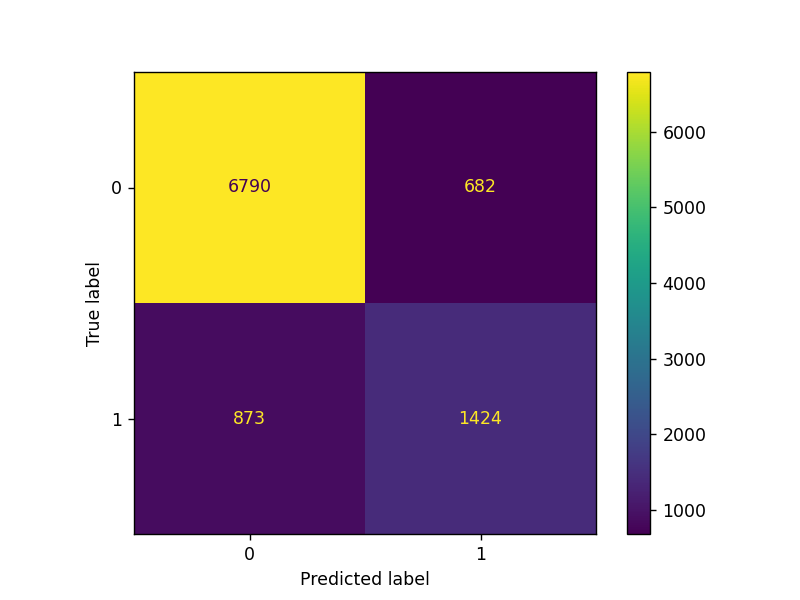



##################### DataFrame : Dataset : KNN Imputation   #####################
---------------------------- Dummy Encoding (X) ---------------------


-------------------------------  X -------------------------------


,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39.0,6.0,13.0,4.0,0.0,1.0,4.0,1.0,2174.0,0.0,40.0,38.0
1,50.0,5.0,13.0,2.0,3.0,0.0,4.0,1.0,0.0,0.0,13.0,38.0
2,38.0,3.0,9.0,0.0,5.0,1.0,4.0,1.0,0.0,0.0,40.0,38.0




-------------------------------  y  -------------------------------


,1.0
0,0
1,0
2,0


 Split Datasets : X_train(39073, 12), X_test(9769, 12), y_train(39073, 1), y_test(9769, 1)


C:\Users\singg\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\singg\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


confusion : 
 [[6948  524]
 [ 961 1336]]
accuracy :  0.8479885351622479
precison :  0.7983862130660999
recall :  0.7557498655261168
f1 : 0.7731117702725092
Std_score :  0.8479885351622479


C:\Users\singg\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


<IPython.core.display.Javascript object>


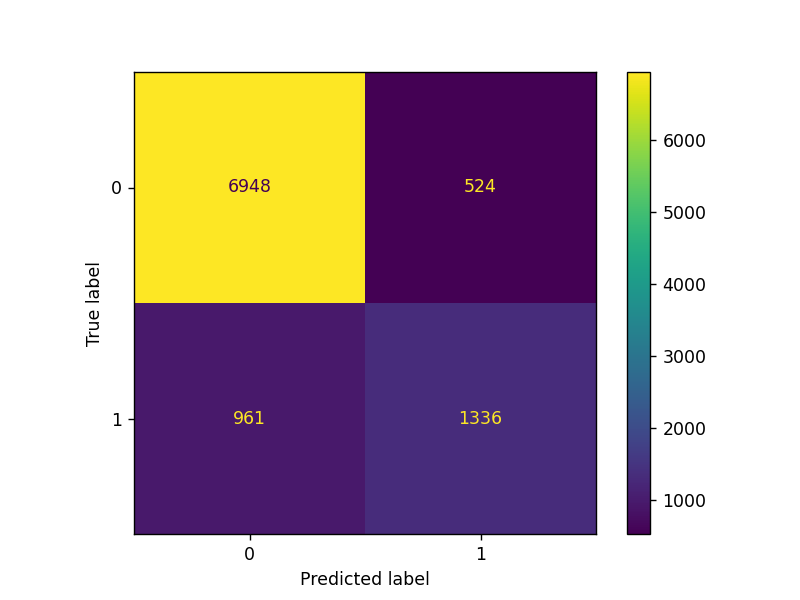



Original X_test


,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.328767,0.375,0.533333,0.333333,0.714286,0.0,1.00,1.0,0.000000,0.0,0.397959,0.926829
1,0.547945,0.625,1.000000,0.000000,0.642857,0.2,1.00,0.0,0.000000,0.0,0.244898,0.926829
2,0.191781,0.125,0.800000,0.666667,0.642857,0.6,1.00,0.0,0.165795,0.0,0.397959,0.926829
3,0.520548,0.375,0.666667,0.333333,0.428571,0.0,1.00,1.0,0.000000,0.0,0.193878,0.926829
4,0.575342,0.625,0.333333,0.333333,0.285714,0.0,1.00,1.0,0.000000,0.0,0.397959,0.926829
...,...,...,...,...,...,...,...,...,...,...,...,...
9764,0.561644,0.375,0.533333,1.000000,0.785714,0.2,1.00,1.0,0.000000,0.0,0.377551,0.926829
9765,0.191781,0.750,0.533333,0.666667,0.714286,0.4,0.25,1.0,0.000000,0.0,0.397959,0.926829
9766,0.301370,0.375,0.600000,0.333333,0.785714,0.0,1.00,1.0,0.000000,0.0,0.397959,0.707317
9767,0.287671,0.375,0.666667,0.000000,0.857143,0.2,1.00,0.0,0.000000,0.0,0.397959,0.926829



######################   Feature Test : age   ############################

----------------------  Before permutation : 
 0       0.328767
1       0.547945
2       0.191781
3       0.520548
4       0.575342
          ...   
9764    0.561644
9765    0.191781
9766    0.301370
9767    0.287671
9768    0.178082
Name: age, Length: 9769, dtype: float64

----------------------   After permutation : 
 [0.28767123 0.34246575 0.10958904 ... 0.39726027 0.52054795 0.36986301]


C:\Users\singg\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\singg\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\singg\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(



accuracy_score : 0.8328385709898659 

######################   Feature Test : workclass   ############################

----------------------  Before permutation : 
 0       0.375
1       0.625
2       0.125
3       0.375
4       0.625
        ...  
9764    0.375
9765    0.750
9766    0.375
9767    0.375
9768    0.375
Name: workclass, Length: 9769, dtype: float64

----------------------   After permutation : 
 [0.375 0.375 0.625 ... 0.5   0.375 0.375]


C:\Users\singg\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\singg\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(



accuracy_score : 0.8273108813594022 

######################   Feature Test : education-num   ############################

----------------------  Before permutation : 
 0       0.533333
1       1.000000
2       0.800000
3       0.666667
4       0.333333
          ...   
9764    0.533333
9765    0.533333
9766    0.600000
9767    0.666667
9768    0.800000
Name: education-num, Length: 9769, dtype: float64

----------------------   After permutation : 
 [0.6        0.53333333 0.6        ... 0.8        0.13333333 0.8       ]


C:\Users\singg\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)



accuracy_score : 0.7945542020677654 

######################   Feature Test : marital-status   ############################

----------------------  Before permutation : 
 0       0.333333
1       0.000000
2       0.666667
3       0.333333
4       0.333333
          ...   
9764    1.000000
9765    0.666667
9766    0.333333
9767    0.000000
9768    0.333333
Name: marital-status, Length: 9769, dtype: float64

----------------------   After permutation : 
 [0.33333333 0.         0.33333333 ... 0.66666667 0.33333333 1.        ]


C:\Users\singg\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\singg\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)



accuracy_score : 0.7754120176067151 

######################   Feature Test : occupation   ############################

----------------------  Before permutation : 
 0       0.714286
1       0.642857
2       0.642857
3       0.428571
4       0.285714
          ...   
9764    0.785714
9765    0.714286
9766    0.785714
9767    0.857143
9768    0.642857
Name: occupation, Length: 9769, dtype: float64

----------------------   After permutation : 
 [0.21428571 0.         0.71428571 ... 0.21428571 0.78571429 0.78571429]


C:\Users\singg\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\singg\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)



accuracy_score : 0.7615927935305559 

######################   Feature Test : relationship   ############################

----------------------  Before permutation : 
 0       0.0
1       0.2
2       0.6
3       0.0
4       0.0
       ... 
9764    0.2
9765    0.4
9766    0.0
9767    0.2
9768    0.0
Name: relationship, Length: 9769, dtype: float64

----------------------   After permutation : 
 [0.6 0.  0.  ... 0.  0.6 0.8]


C:\Users\singg\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\singg\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\singg\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(



accuracy_score : 0.7514586958747057 

######################   Feature Test : race   ############################

----------------------  Before permutation : 
 0       1.00
1       1.00
2       1.00
3       1.00
4       1.00
        ... 
9764    1.00
9765    0.25
9766    1.00
9767    1.00
9768    1.00
Name: race, Length: 9769, dtype: float64

----------------------   After permutation : 
 [1.   1.   1.   ... 1.   0.25 1.  ]


C:\Users\singg\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\singg\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(



accuracy_score : 0.7514586958747057 

######################   Feature Test : sex   ############################

----------------------  Before permutation : 
 0       1.0
1       0.0
2       0.0
3       1.0
4       1.0
       ... 
9764    1.0
9765    1.0
9766    1.0
9767    0.0
9768    1.0
Name: sex, Length: 9769, dtype: float64

----------------------   After permutation : 
 [1. 1. 1. ... 0. 0. 1.]


C:\Users\singg\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)



accuracy_score : 0.748183027945542 

######################   Feature Test : capital-gain   ############################

----------------------  Before permutation : 
 0       0.000000
1       0.000000
2       0.165795
3       0.000000
4       0.000000
          ...   
9764    0.000000
9765    0.000000
9766    0.000000
9767    0.000000
9768    0.000000
Name: capital-gain, Length: 9769, dtype: float64

----------------------   After permutation : 
 [0. 0. 0. ... 0. 0. 0.]


C:\Users\singg\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\singg\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)



accuracy_score : 0.7365134609478964 

######################   Feature Test : capital-loss   ############################

----------------------  Before permutation : 
 0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9764    0.0
9765    0.0
9766    0.0
9767    0.0
9768    0.0
Name: capital-loss, Length: 9769, dtype: float64

----------------------   After permutation : 
 [0. 0. 0. ... 0. 0. 0.]


C:\Users\singg\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\singg\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)



accuracy_score : 0.733340157641519 

######################   Feature Test : hours-per-week   ############################

----------------------  Before permutation : 
 0       0.397959
1       0.244898
2       0.397959
3       0.193878
4       0.397959
          ...   
9764    0.377551
9765    0.397959
9766    0.397959
9767    0.397959
9768    0.397959
Name: hours-per-week, Length: 9769, dtype: float64

----------------------   After permutation : 
 [0.24489796 0.39795918 0.39795918 ... 0.14285714 0.39795918 0.34693878]


C:\Users\singg\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\singg\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\singg\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(



accuracy_score : 0.7301668543351417 

######################   Feature Test : native-country   ############################

----------------------  Before permutation : 
 0       0.926829
1       0.926829
2       0.926829
3       0.926829
4       0.926829
          ...   
9764    0.926829
9765    0.926829
9766    0.707317
9767    0.926829
9768    0.926829
Name: native-country, Length: 9769, dtype: float64

----------------------   After permutation : 
 [0.82926829 0.6097561  0.92682927 ... 1.         0.92682927 0.02439024]

accuracy_score : 0.7301668543351417 


######################################### Score Table #########################################



C:\Users\singg\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.832839,0.827311,0.794554,0.775412,0.761593,0.751459,0.751459,0.748183,0.736513,0.73334,0.730167,0.730167


In [26]:
if __name__ == "__main__" :
    
   
   ##################### Loading Data ###################
    df = pd.read_csv("adult.csv", header=None)
    df.names = "Original Dataset"
    
    ##################### Exploring and Manipulating DataFrame #############
    explore_df(df, 1)
    
    
    ###Exploring Categorical Variables
    result_explore_cat(df)
    ###Manipuating Categorical Variables
    df_cat_n = manip_cat_v(df, cat_list).copy()
    
    ###Exploring Continuous Variables
    result_explore_conti(df)
    ###Manipulating Continuous Variables
    obj_con =["capital-gain"]
    df_cat_con_n = manip_con_v(df_cat_n, obj_con)
    df_cat_con_n.names = "before KNN imputation(+nan/None)"
    explore_df(df_cat_con_n, 2)    
    
    
    ##################### KNN IMPUTATION     
    ###KNN Imputation
    imputed_df = KNN_imp(df_cat_con_n, cat_list)
    imputed_df.names = "Dataset : KNN Imputation "
    
    
    ######################### KNN (Beforing Tunning)
    print("####################   KNN Before Tuning ")
    b_knn, b_pred, X_train, X_test, y_train, y_test = basic_knn(imputed_df, "salary", cat_list)
    evaluating_models(X_train, X_test, y_test, b_pred, model=b_knn, average='macro')
    
    ############################    Training Modles  ########################## 
    ####################### 0. X: (NULL) KNN IMPUTATION + Dummy Encoded + NORMALIZATION 
    ####################### 1. X: (NULL) KNN IMPUTATION + NORMAIZATION     
    ################################    GridSerchCV   ##################### 
    ####################### n_neighbors = range(1,30,2)
    ####################### weights = "uniform", "distance"
    ####################### algorithm = "auto","ball_tree","kd_tree","brute"
    ####################### metric = "euclidean"
    
    
    ###----------------------------------!!!!!! It takes more than 3 hours
    #print(cat_list)
    #X_train, X_test, y_train, y_test = s_dataset(imputed_df, "salary", cat_list, 0)
    #scores_0, best_p_0, best_s_0  = ex_knn(X_train, X_test, y_train, y_test)

    #X_train, X_test, y_train, y_test = s_dataset(imputed_df, "salary", cat_list, 1)
    #scores_1, best_p_1, best_s_1  = ex_knn(X_train, X_test, y_train, y_test)
    
    ###------------------------- Best Parameter for the final Model, getting variables from the GridSerchCV
    #param, flag = best_param(best_p_0, best_s_0,best_p_1, best_s_1)
    
    
    ######################  Best Parameter for the final Model, values ############# 
    param = {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 29, 'weights': 'uniform'}
    flag = 0
    
    ############################   Final Model  ########################## 
    
    X_train, X_test, y_train, y_test = s_dataset(imputed_df, "salary", cat_list, flag)
    knn, pred = ex_knn_final(X_train, X_test, y_train, y_test, param)
    evaluating_models(X_train, X_test, y_test, pred, model=knn, average='macro')
    
    feature_importance(X_train, X_test, y_train, y_test,df)
    